In [2]:
import networkx as nx
import pickle

import numpy as np; np.set_printoptions(suppress=True, linewidth=180); np.seterr(divide='ignore')
import pandas as pd; pd.set_option('display.width', 500)
import matplotlib.pyplot as plt

from plot_module import plot_ode_results, plot_sde_results, plot_simulator_graph, plot_neuron_graph_subset, plot_twocomponent_results
from sim_param_from_network import names_from_network, sde_param_from_network, ode_from_network, start_state_from_nodes
from neuron_graph_process import neuron_graph_process
from neuron_graph_helper import load_pickled_neuron_graph
from analyse_simulation import two_component_statistics

from simulate import simulate_ode, simulate_gillespie, simulate_tauleaping

In [ ]:
model = 'model_0'

In [12]:
G = load_pickled_neuron_graph(f'neuron_graphs/{model}.pkl')

In [13]:
DELTA = 0.25
for node, data in G.nodes(data = True):
    if data['nodetype'] == 1:
        data['delta'] = DELTA

VARS, NODES = names_from_network(G)
START_STATE = start_state_from_nodes(G, heteroplasmy=0.5, delta=DELTA)


# get the parameter values for which the simulations will be run
C_B_val = sequence = [round(i * 10**-decimals, 14) for decimals in range(2, 13) for i in range(10, 0, -1)]
C_B_val = [element for i, element in enumerate(C_B_val) if i % 10 == 0] # sparseify for testing
print(f"preparing to simulate {model} with the following parameters:")
print(C_B_val, '\n')

preparing to simulate with the following parameters:
[0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09, 1e-10, 1e-11] 




<<<< STARTING SIMULATION WITH C_B = 0.1 >>>>

simulating using gillespie...




  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:02<02:11,  2.23s/it]

  3%|▎         | 2/60 [00:06<03:16,  3.39s/it]

  5%|▌         | 3/60 [00:07<02:06,  2.22s/it]

  8%|▊         | 5/60 [00:07<00:55,  1.01s/it]

 15%|█▌        | 9/60 [00:07<00:21,  2.34it/s]

 17%|█▋        | 10/60 [00:07<00:18,  2.64it/s]

 20%|██        | 12/60 [00:07<00:12,  3.71it/s]

 23%|██▎       | 14/60 [00:14<00:55,  1.20s/it]

 25%|██▌       | 15/60 [00:14<00:48,  1.09s/it]

 28%|██▊       | 17/60 [00:14<00:31,  1.38it/s]

 32%|███▏      | 19/60 [00:15<00:20,  2.01it/s]

 35%|███▌      | 21/60 [00:15<00:16,  2.42it/s]

 38%|███▊      | 23/60 [00:15<00:11,  3.34it/s]

 42%|████▏     | 25/60 [00:17<00:14,  2.35it/s]

 43%|████▎     | 26/60 [00:21<00:37,  1.10s/it]

 45%|████▌     | 27/60 [00:21<00:29,  1.10it/s]

 48%|████▊     | 29/60 [00:21<00:18,  1.68it/s]

 57%|█████▋    | 34/60 [00:21<00:06,  3.72it/s]

 62%|██████▏   | 37/60 [00:21<00:04,  4.78it/s]

 65%|██████▌   | 39/60 [00:22<00


Copy number:
wilcox. test: greater p= 0.0
pooled t test: greater p= 0.0004
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

Eff. pop. size:
wilcox. test: none p= 0.3182
pooled t test: none p= 0.4623
mk trend: no trend p= 0.4258
kpss: stationary p= 0.1

Heteroplasmy:
wilcox. test: greater p= 0.0
pooled t test: greater p= 0.0012
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

           t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  s_wt_mean  s_wt_sem  s_mt_mean  s_mt_sem  a_wt_mean  a_wt_sem  a_mt_mean  a_mt_sem
0        0.0   640.00    0.00    400.00     0.00    0.5000   0.0000   0.0000   0.0000     0.0     160.00      0.00      160.0      0.00     160.00      0.00     160.00      0.00
1000  4000.0  1580.58   19.77    400.21     0.19    0.9833   0.0165   0.9833   0.0167     0.0       3.33      3.31      785.7     13.23       3.42      3.39     788.13     13.27



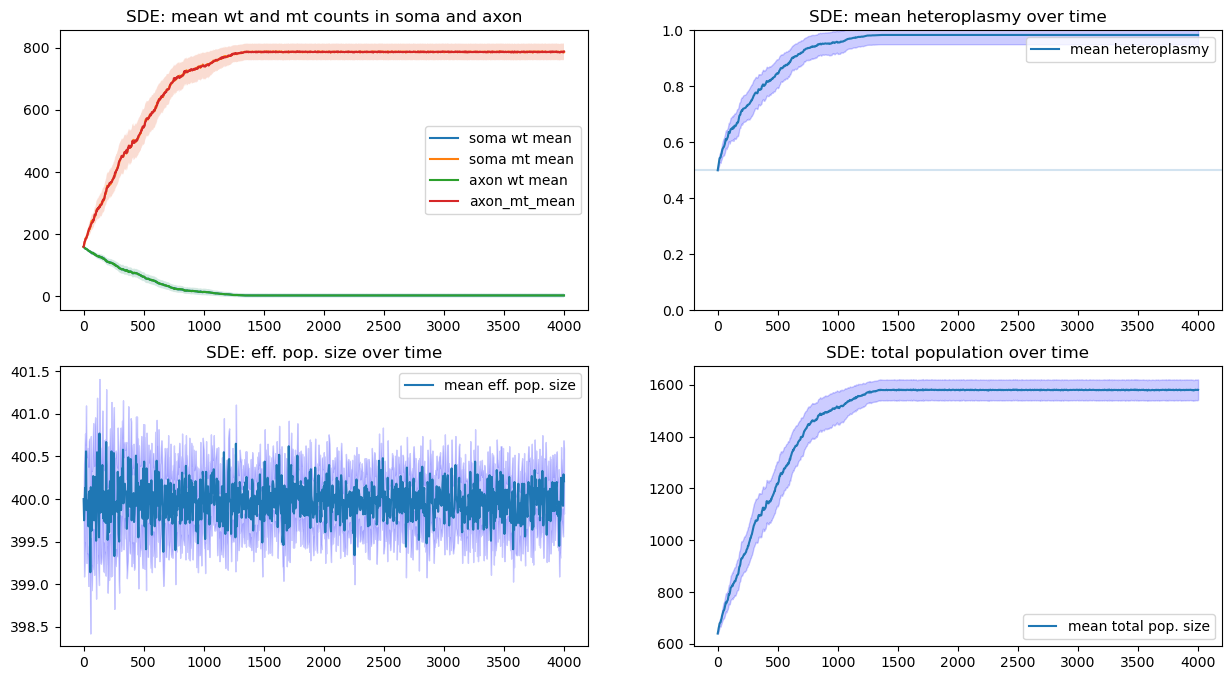

simulating using tau leaping...




  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:03<03:31,  3.58s/it]

  7%|▋         | 4/60 [00:03<00:39,  1.42it/s]

 10%|█         | 6/60 [00:03<00:23,  2.31it/s]

 15%|█▌        | 9/60 [00:04<00:13,  3.90it/s]

 18%|█▊        | 11/60 [00:04<00:09,  5.09it/s]

 22%|██▏       | 13/60 [00:07<00:28,  1.66it/s]

 25%|██▌       | 15/60 [00:07<00:20,  2.22it/s]

 28%|██▊       | 17/60 [00:07<00:14,  2.88it/s]

 35%|███▌      | 21/60 [00:07<00:08,  4.86it/s]

 38%|███▊      | 23/60 [00:07<00:06,  5.70it/s]

 42%|████▏     | 25/60 [00:09<00:13,  2.57it/s]

 43%|████▎     | 26/60 [00:10<00:15,  2.18it/s]

 48%|████▊     | 29/60 [00:10<00:08,  3.45it/s]

 52%|█████▏    | 31/60 [00:11<00:06,  4.25it/s]

 55%|█████▌    | 33/60 [00:11<00:05,  5.25it/s]

 60%|██████    | 36/60 [00:11<00:03,  7.38it/s]

 63%|██████▎   | 38/60 [00:13<00:09,  2.24it/s]

 68%|██████▊   | 41/60 [00:14<00:05,  3.33it/s]

 72%|███████▏  | 43/60 [00:14<00:04,  4.09it/s]

 75%|███████▌  | 45/60 [00:14<0


Copy number:
wilcox. test: greater p= 0.0
pooled t test: greater p= 0.0005
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

Eff. pop. size:
wilcox. test: none p= 0.7193
pooled t test: none p= 0.5187
mk trend: no trend p= 0.0685
kpss: non-stationary p= 0.0461

Heteroplasmy:
wilcox. test: greater p= 0.0
pooled t test: greater p= 0.0013
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

           t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  s_wt_mean  s_wt_sem  s_mt_mean  s_mt_sem  a_wt_mean  a_wt_sem  a_mt_mean  a_mt_sem
0        0.0   640.00    0.00    400.00     0.00    0.5000   0.0000   0.0000   0.0000     0.0      160.0      0.00      160.0      0.00      160.0      0.00     160.00      0.00
1000  4000.0  1560.03   27.77    400.06     0.22    0.9667   0.0232   0.9667   0.0333     0.0        6.8      4.73      773.5     18.55        6.6      4.59     773.13     18.55



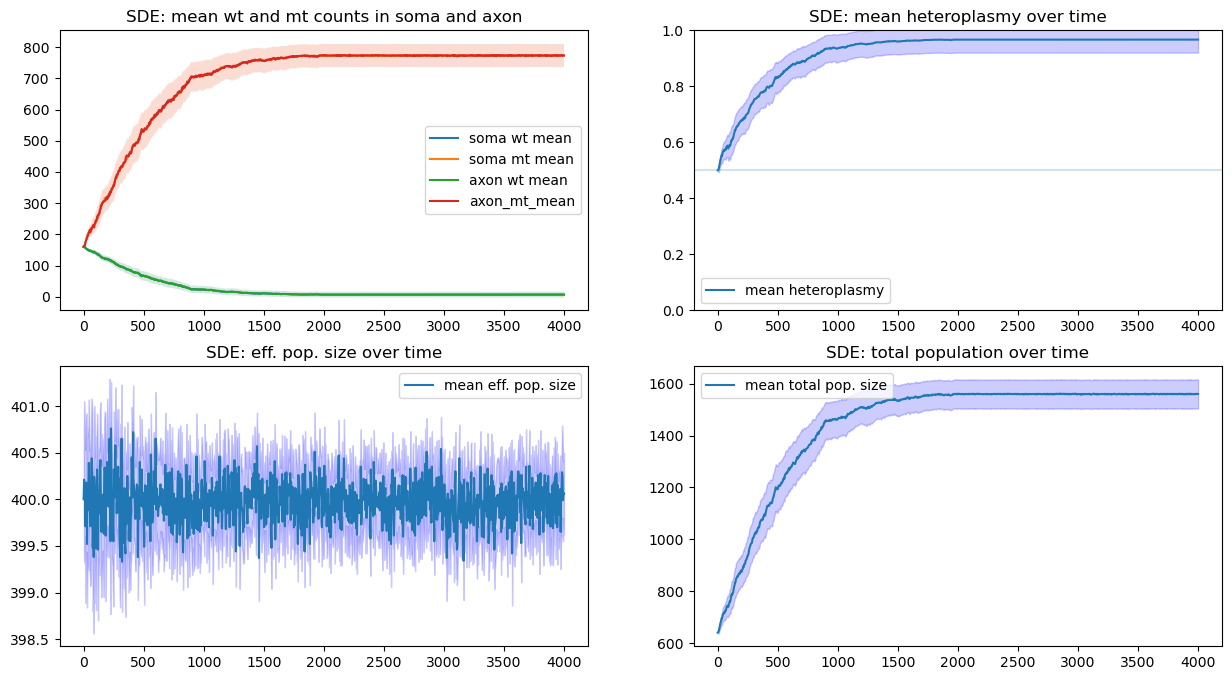


 ----- 


<<<< STARTING SIMULATION WITH C_B = 0.01 >>>>

simulating using gillespie...




  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:02<02:02,  2.08s/it]

  5%|▌         | 3/60 [00:06<02:05,  2.20s/it]

  7%|▋         | 4/60 [00:07<01:35,  1.71s/it]

  8%|▊         | 5/60 [00:07<01:04,  1.18s/it]

 18%|█▊        | 11/60 [00:07<00:16,  3.05it/s]

 22%|██▏       | 13/60 [00:07<00:13,  3.56it/s]

 25%|██▌       | 15/60 [00:08<00:11,  3.97it/s]

 28%|██▊       | 17/60 [00:09<00:13,  3.25it/s]

 38%|███▊      | 23/60 [00:09<00:05,  6.54it/s]

 42%|████▏     | 25/60 [00:09<00:05,  6.71it/s]

 45%|████▌     | 27/60 [00:09<00:04,  7.35it/s]

 48%|████▊     | 29/60 [00:10<00:06,  5.16it/s]

 52%|█████▏    | 31/60 [00:10<00:04,  6.24it/s]

 55%|█████▌    | 33/60 [00:10<00:04,  6.40it/s]

 60%|██████    | 36/60 [00:11<00:02,  8.84it/s]

 63%|██████▎   | 38/60 [00:11<00:02,  8.43it/s]

 67%|██████▋   | 40/60 [00:11<00:02,  9.58it/s]

 70%|███████   | 42/60 [00:12<00:02,  6.27it/s]

 73%|███████▎  | 44/60 [00:12<00:02,  7.63it/s]

 77%|███████▋  | 46/60 [00:12<0


Copy number:
wilcox. test: greater p= 0.0
pooled t test: greater p= 0.0041
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

Eff. pop. size:
wilcox. test: none p= 0.988
pooled t test: none p= 0.8438
mk trend: increasing p= 0.0106
kpss: non-stationary p= 0.01

Heteroplasmy:
wilcox. test: greater p= 0.0
pooled t test: greater p= 0.013
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

           t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  s_wt_mean  s_wt_sem  s_mt_mean  s_mt_sem  a_wt_mean  a_wt_sem  a_mt_mean  a_mt_sem
0        0.0   640.00    0.00    400.00     0.00    0.5000   0.0000   0.0000   0.0000     0.0     160.00      0.00     160.00      0.00     160.00       0.0     160.00      0.00
1000  4000.0  1460.77   49.85    400.13     0.69    0.8833   0.0414   0.8833   0.1167     0.0      23.23      8.26     709.13     33.32      23.35       8.3     705.05     33.14



 60%|██████    | 36/60 [26:32:09<17:41:26, 2653.59s/it]


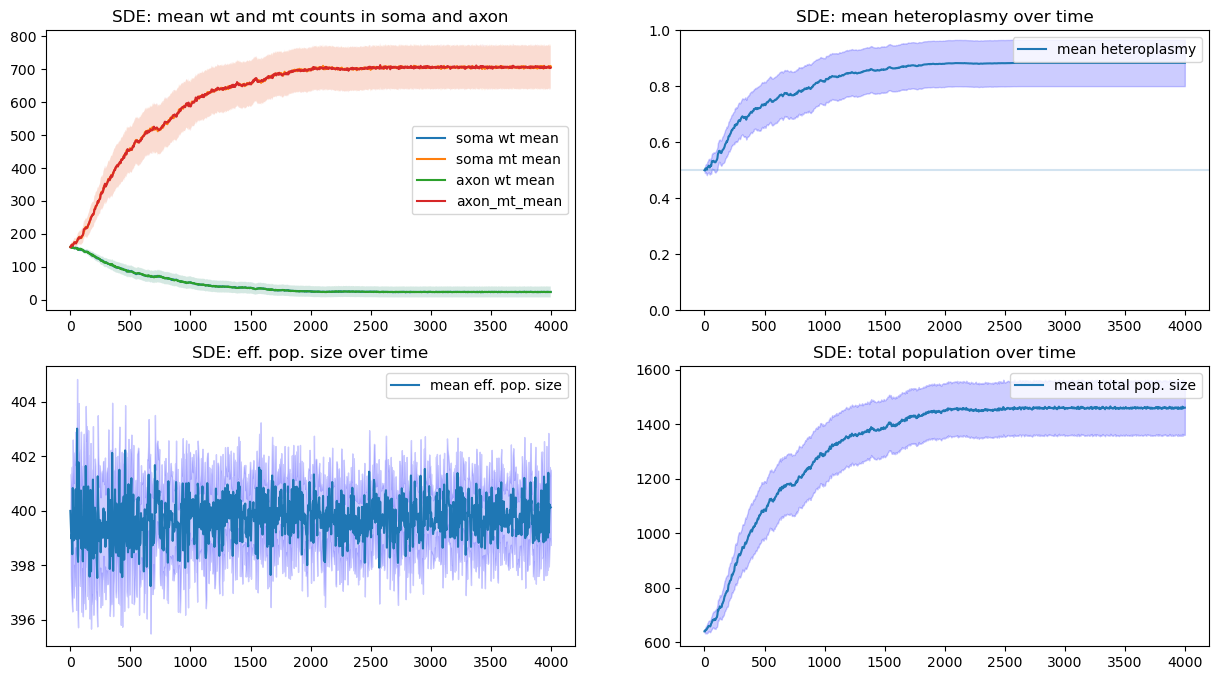

simulating using tau leaping...


100%|██████████| 60/60 [00:17<00:00,  3.53it/s]



Copy number:
wilcox. test: greater p= 0.0
pooled t test: greater p= 0.0019
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

Eff. pop. size:
wilcox. test: none p= 0.2416
pooled t test: less p= 0.0263
mk trend: increasing p= 0.0145
kpss: non-stationary p= 0.01

Heteroplasmy:
wilcox. test: greater p= 0.0
pooled t test: greater p= 0.0051
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

           t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  s_wt_mean  s_wt_sem  s_mt_mean  s_mt_sem  a_wt_mean  a_wt_sem  a_mt_mean  a_mt_sem
0        0.0   640.00    0.00    400.00     0.00    0.5000   0.0000   0.0000   0.0000     0.0     160.00      0.00     160.00      0.00      160.0      0.00      160.0      0.00
1000  4000.0  1557.25   28.02    399.15     0.68    0.9667   0.0232   0.9667   0.0333     0.0       6.52      4.53     771.13     18.63        6.6      4.59      773.0     18.62



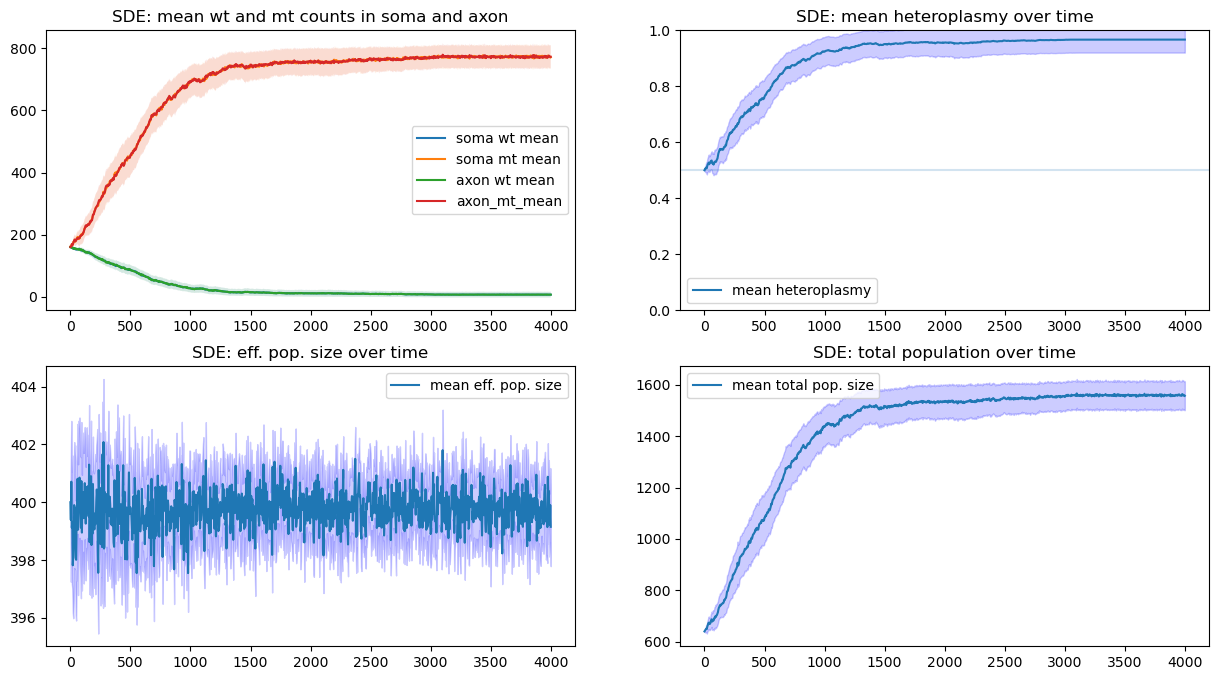


 ----- 


<<<< STARTING SIMULATION WITH C_B = 0.001 >>>>

simulating using gillespie...


100%|██████████| 60/60 [00:23<00:00,  2.52it/s]



Copy number:
wilcox. test: greater p= 0.0002
pooled t test: greater p= 0.0092
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

Eff. pop. size:
wilcox. test: none p= 0.7199
pooled t test: none p= 0.8363
mk trend: no trend p= 0.1314
kpss: stationary p= 0.1

Heteroplasmy:
wilcox. test: none p= 0.5124
pooled t test: none p= 0.2759
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

           t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  s_wt_mean  s_wt_sem  s_mt_mean  s_mt_sem  a_wt_mean  a_wt_sem  a_mt_mean  a_mt_sem
0        0.0   640.00    0.00    400.00     0.00    0.5000   0.0000   0.0000     0.00     0.0     160.00      0.00     160.00      0.00     160.00      0.00     160.00      0.00
1000  4000.0  1046.93   77.71    398.55     3.66    0.5438   0.0638   0.5333     0.45     0.0      90.73     12.74     433.18     51.56      91.68     12.79     431.33     51.34



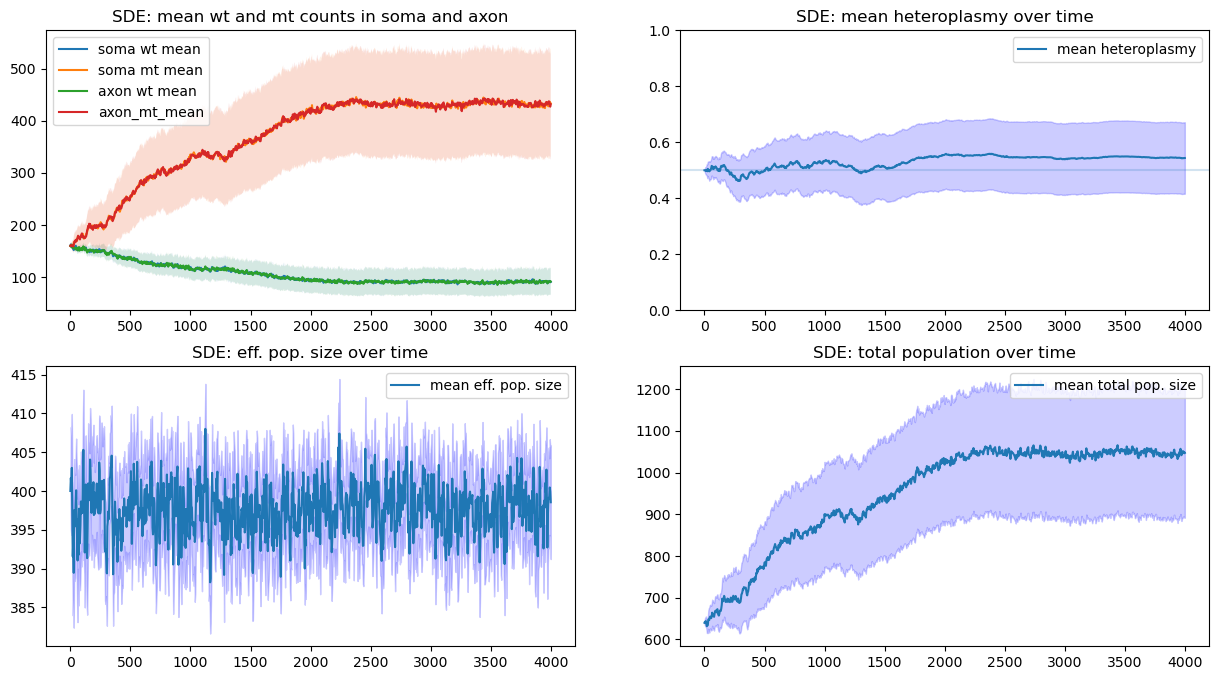

simulating using tau leaping...


100%|██████████| 60/60 [00:14<00:00,  4.06it/s]



Copy number:
wilcox. test: greater p= 0.0
pooled t test: greater p= 0.0197
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

Eff. pop. size:
wilcox. test: none p= 0.656
pooled t test: none p= 0.1714
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

Heteroplasmy:
wilcox. test: greater p= 0.0001
pooled t test: none p= 0.082
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

           t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  s_wt_mean  s_wt_sem  s_mt_mean  s_mt_sem  a_wt_mean  a_wt_sem  a_mt_mean  a_mt_sem
0        0.0   640.00    0.00    400.00     0.00      0.50   0.0000     0.00     0.00     0.0      160.0      0.00     160.00       0.0     160.00      0.00      160.0      0.00
1000  4000.0  1295.45   67.47    398.16     2.82      0.75   0.0559     0.75     0.25     0.0       48.8     10.96     600.28      45.0      50.27     11.33      596.1     44.62



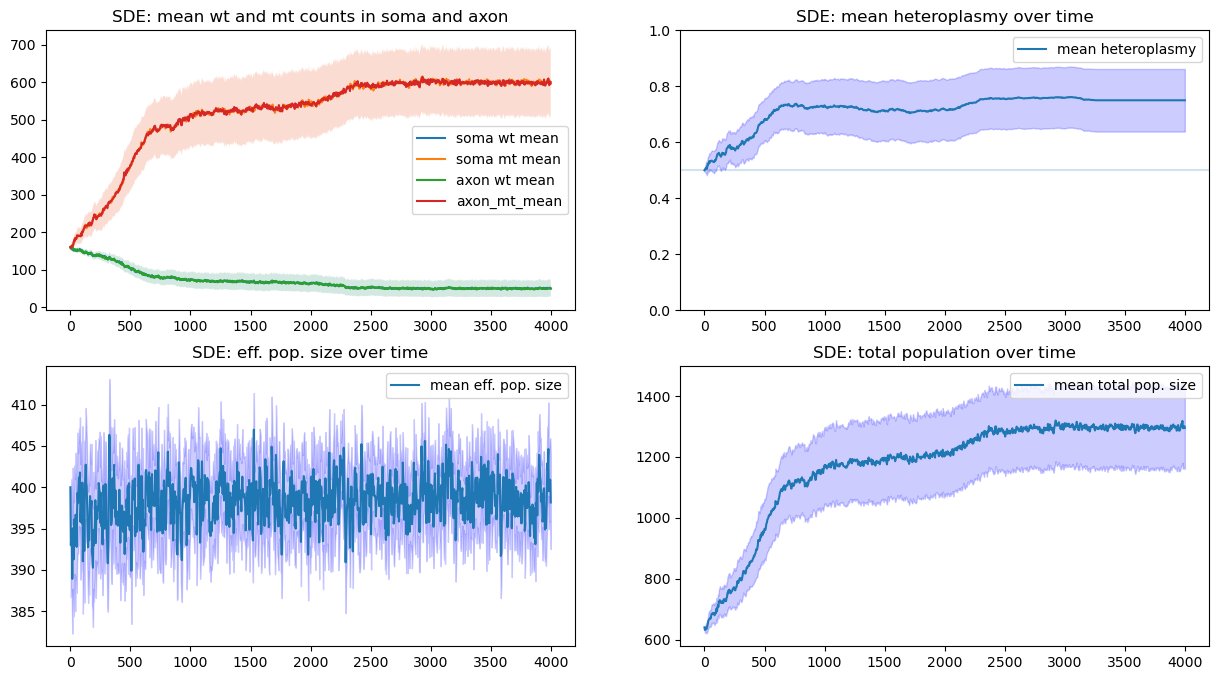


 ----- 


<<<< STARTING SIMULATION WITH C_B = 0.0001 >>>>

simulating using gillespie...


100%|██████████| 60/60 [00:12<00:00,  4.94it/s]



Copy number:
wilcox. test: greater p= 0.0359
pooled t test: greater p= 0.0235
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

Eff. pop. size:
wilcox. test: less p= 0.0028
pooled t test: none p= 0.269
mk trend: decreasing p= 0.0001
kpss: stationary p= 0.1

Heteroplasmy:
wilcox. test: none p= 0.1967
pooled t test: less p= 0.0377
mk trend: decreasing p= 0.0
kpss: non-stationary p= 0.01

           t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  s_wt_mean  s_wt_sem  s_mt_mean  s_mt_sem  a_wt_mean  a_wt_sem  a_mt_mean  a_mt_sem
0        0.0   640.00    0.00    400.00      0.0    0.5000   0.0000   0.0000   0.0000     0.0     160.00      0.00     160.00      0.00     160.00      0.00     160.00      0.00
1000  4000.0   857.87   76.97    373.53      8.2    0.4167   0.0636   0.4167   0.5833     0.0     106.12     12.23     322.45     49.71     105.97     12.22     323.33     49.85



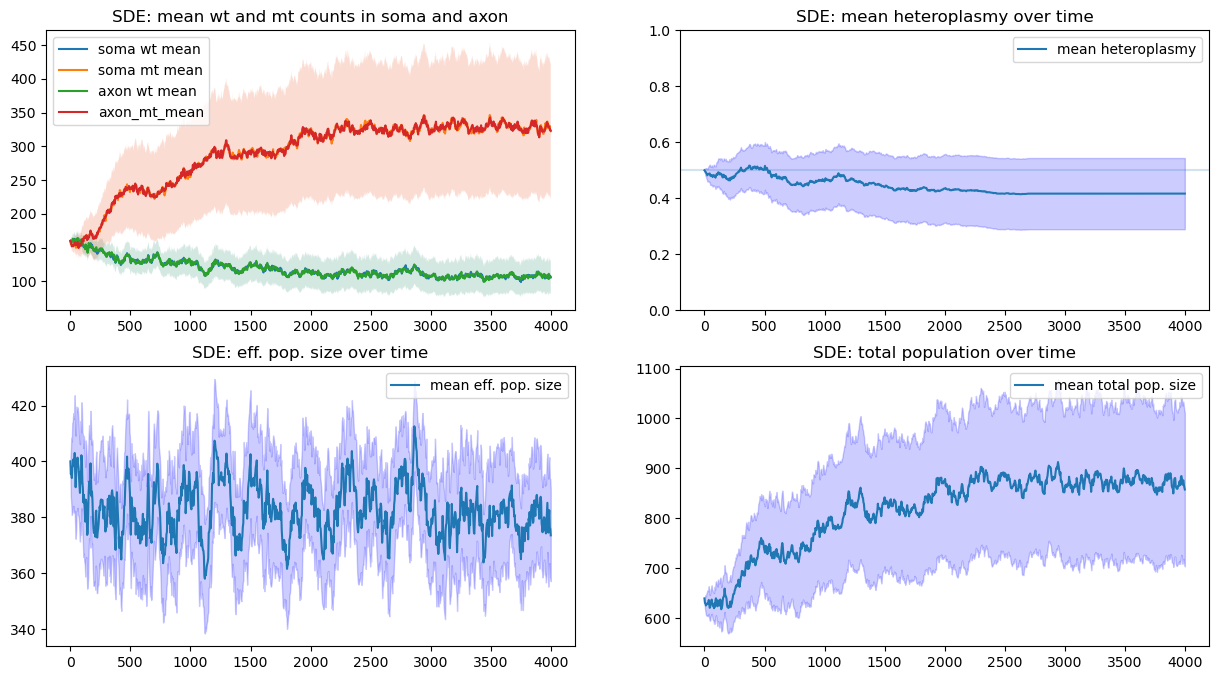

simulating using tau leaping...


100%|██████████| 60/60 [00:17<00:00,  3.38it/s]



Copy number:
wilcox. test: greater p= 0.0002
pooled t test: greater p= 0.0141
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

Eff. pop. size:
wilcox. test: less p= 0.0423
pooled t test: none p= 0.2592
mk trend: no trend p= 0.0502
kpss: stationary p= 0.1

Heteroplasmy:
wilcox. test: none p= 0.5178
pooled t test: none p= 0.4977
mk trend: increasing p= 0.0
kpss: stationary p= 0.0628

           t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  s_wt_mean  s_wt_sem  s_mt_mean  s_mt_sem  a_wt_mean  a_wt_sem  a_mt_mean  a_mt_sem
0        0.0   640.00    0.00    400.00     0.00    0.5000   0.0000   0.0000     0.00     0.0     160.00      0.00     160.00      0.00     160.00      0.00     160.00      0.00
1000  4000.0  1018.42   78.91    384.49     8.03    0.5416   0.0638   0.5333     0.45     0.0      88.13     12.74     423.87     51.24      85.05     12.26     421.37     51.04



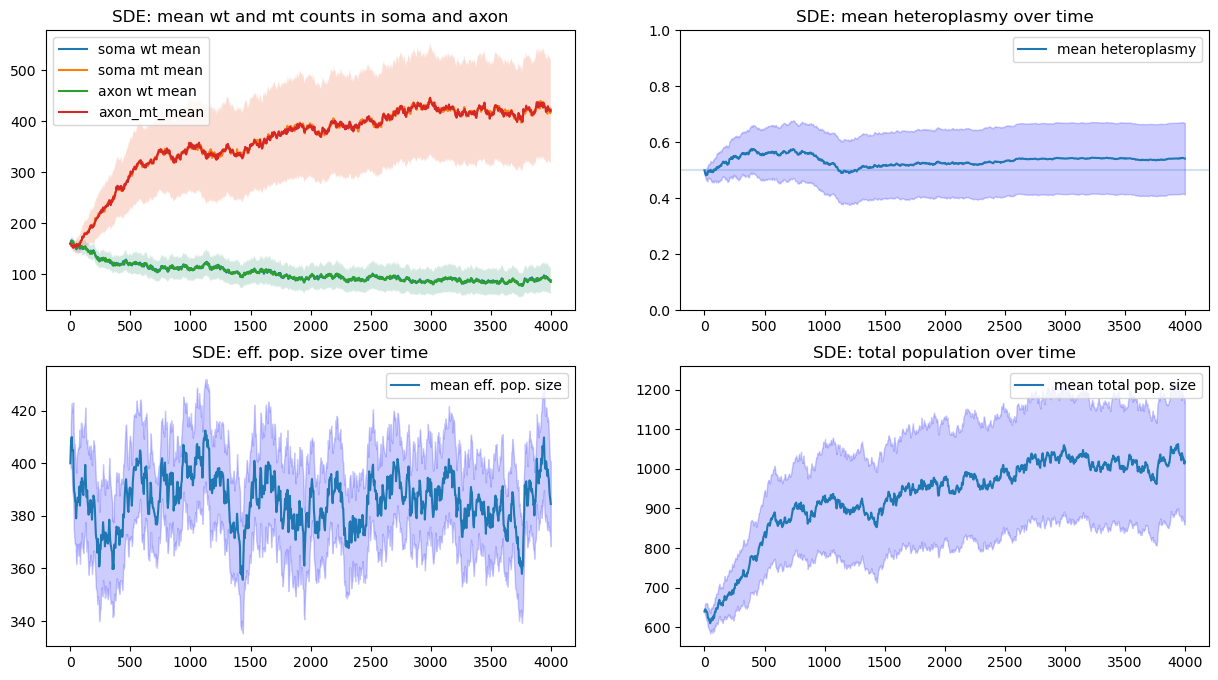


 ----- 


<<<< STARTING SIMULATION WITH C_B = 1e-05 >>>>

simulating using gillespie...


100%|██████████| 60/60 [00:15<00:00,  3.75it/s]



Copy number:
wilcox. test: none p= 0.1576
pooled t test: none p= 0.3202
mk trend: decreasing p= 0.0
kpss: non-stationary p= 0.01

Eff. pop. size:
wilcox. test: less p= 0.0
pooled t test: less p= 0.0098
mk trend: decreasing p= 0.0
kpss: non-stationary p= 0.01

Heteroplasmy:
wilcox. test: greater p= 0.0032
pooled t test: none p= 0.152
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

           t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  s_wt_mean  s_wt_sem  s_mt_mean  s_mt_sem  a_wt_mean  a_wt_sem  a_mt_mean  a_mt_sem
0        0.0   640.00    0.00    400.00     0.00       0.5    0.000      0.0      0.0     0.0     160.00      0.00     160.00      0.00     160.00      0.00     160.00      0.00
1000  4000.0   526.55   92.58    150.88    24.25       0.8    0.073      0.4      0.1     0.5      13.23      6.29     249.33     47.21      12.42      5.63     251.57     46.97



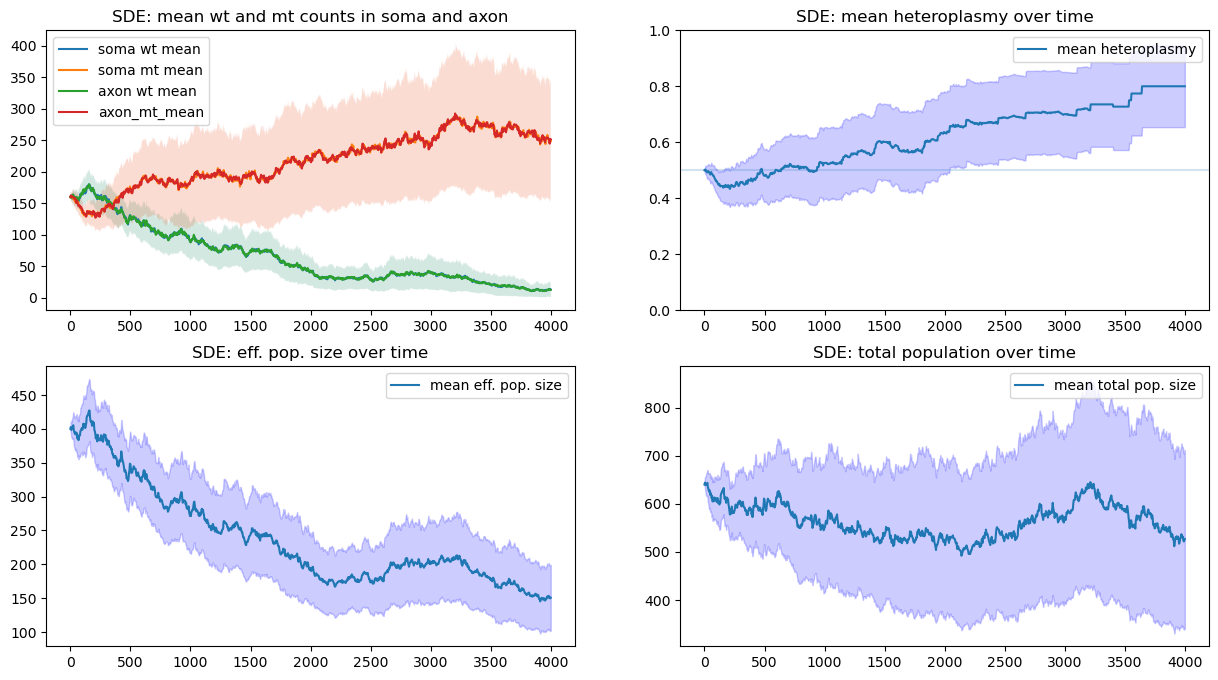

simulating using tau leaping...


100%|██████████| 60/60 [00:11<00:00,  5.07it/s]



Copy number:
wilcox. test: none p= 0.9881
pooled t test: none p= 0.5314
mk trend: increasing p= 0.0
kpss: stationary p= 0.0773

Eff. pop. size:
wilcox. test: less p= 0.0
pooled t test: less p= 0.006
mk trend: decreasing p= 0.0
kpss: non-stationary p= 0.01

Heteroplasmy:
wilcox. test: greater p= 0.0032
pooled t test: greater p= 0.0277
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

           t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  s_wt_mean  s_wt_sem  s_mt_mean  s_mt_sem  a_wt_mean  a_wt_sem  a_mt_mean  a_mt_sem
0        0.0   640.00    0.00    400.00      0.0       0.5    0.000      0.0      0.0     0.0     160.00      0.00     160.00      0.00     160.00       0.0     160.00      0.00
1000  4000.0   667.87  112.97    198.82     30.6       0.8    0.073      0.4      0.1     0.5      20.73      8.84     311.23     57.62      21.73       9.2     314.17     57.86



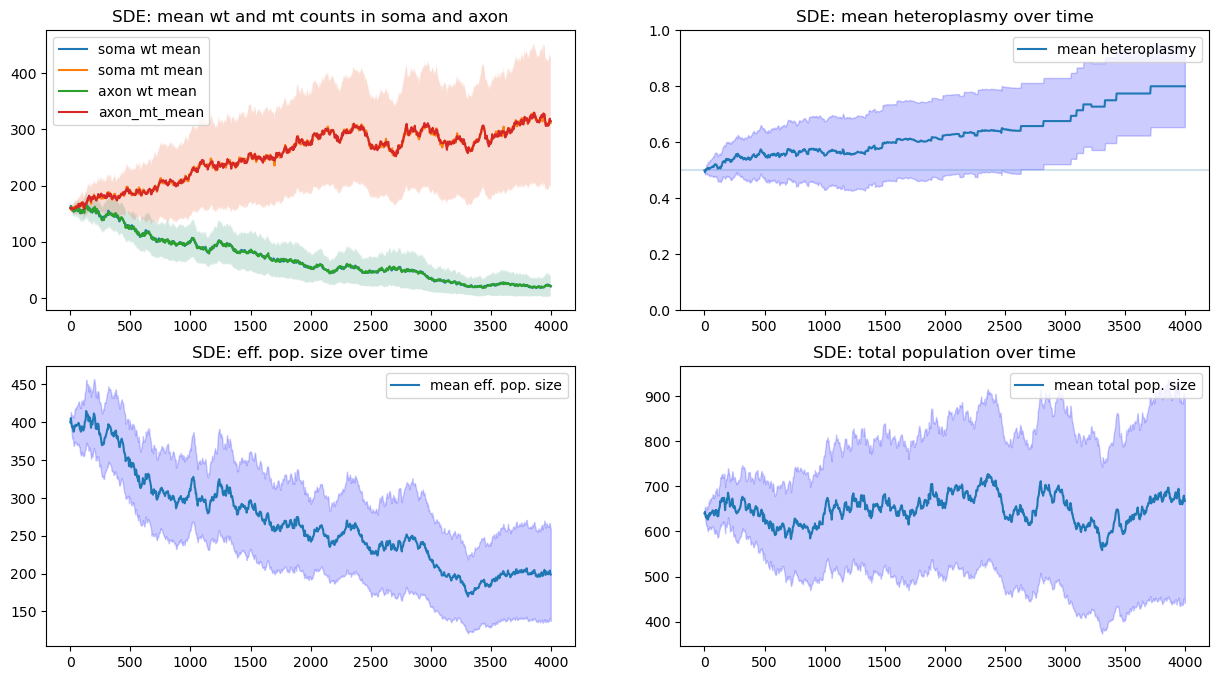


 ----- 


<<<< STARTING SIMULATION WITH C_B = 1e-06 >>>>

simulating using gillespie...


100%|██████████| 60/60 [00:13<00:00,  4.39it/s]



Copy number:
wilcox. test: less p= 0.0
pooled t test: none p= 0.234
mk trend: decreasing p= 0.0
kpss: non-stationary p= 0.01

Eff. pop. size:
wilcox. test: less p= 0.0
pooled t test: none p= 0.0856
mk trend: decreasing p= 0.0
kpss: non-stationary p= 0.01

Heteroplasmy:
wilcox. test: none p= 0.1297
pooled t test: none p= 0.2584
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

           t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  s_wt_mean  s_wt_sem  s_mt_mean  s_mt_sem  a_wt_mean  a_wt_sem  a_mt_mean  a_mt_sem
0        0.0   640.00    0.00    400.00     0.00    0.5000   0.0000      0.0   0.0000     0.0     160.00       0.0     160.00      0.00     160.00      0.00     160.00      0.00
1000  4000.0   387.05  115.16    154.36    44.62    0.7053   0.1044      0.2   0.0833     0.7      37.77      18.2     155.78     55.74      39.03     18.98     154.47     56.52



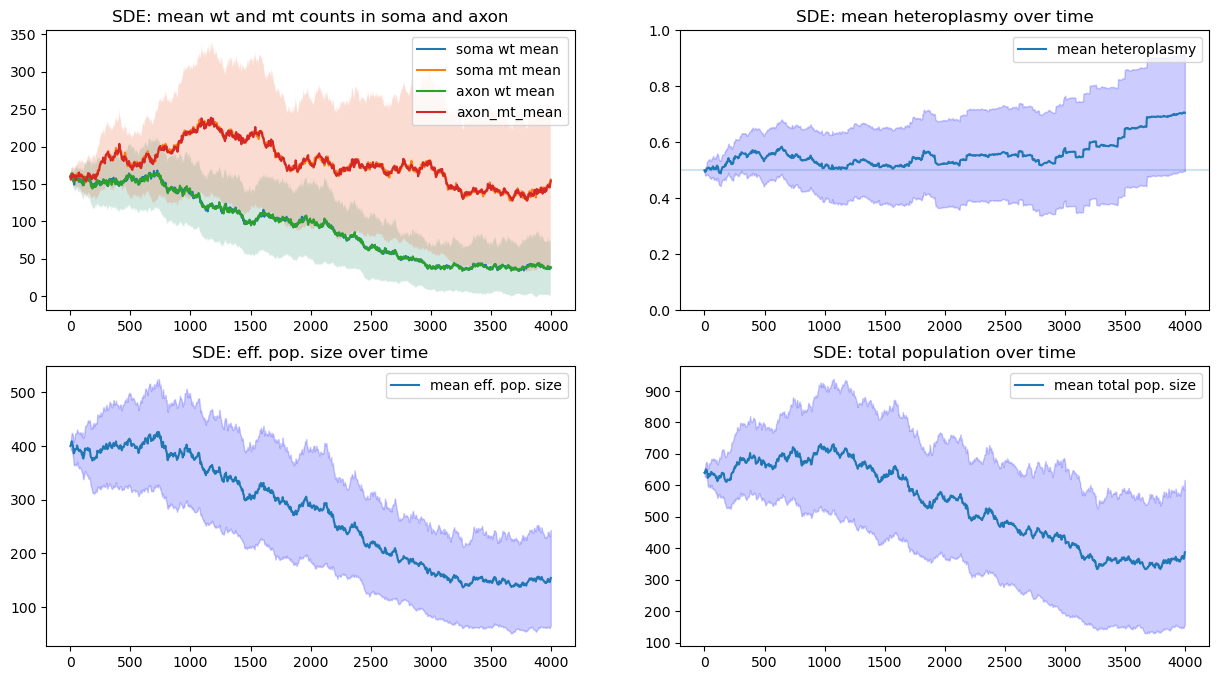

simulating using tau leaping...


100%|██████████| 60/60 [00:09<00:00,  6.33it/s]



Copy number:
wilcox. test: less p= 0.0005
pooled t test: none p= 0.1707
mk trend: decreasing p= 0.0
kpss: non-stationary p= 0.01

Eff. pop. size:
wilcox. test: less p= 0.0
pooled t test: less p= 0.0218
mk trend: decreasing p= 0.0
kpss: non-stationary p= 0.01

Heteroplasmy:
wilcox. test: none p= 0.1454
pooled t test: none p= 0.2327
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

           t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  s_wt_mean  s_wt_sem  s_mt_mean  s_mt_sem  a_wt_mean  a_wt_sem  a_mt_mean  a_mt_sem
0        0.0   640.00    0.00    400.00     0.00    0.5000   0.0000      0.0   0.0000  0.0000     160.00      0.00      160.0      0.00      160.0       0.0     160.00      0.00
1000  4000.0   409.15  115.58    147.41    39.69    0.7059   0.1105      0.2   0.0833  0.7167      28.87     14.71      173.5     57.02       31.3      15.8     175.48     57.58



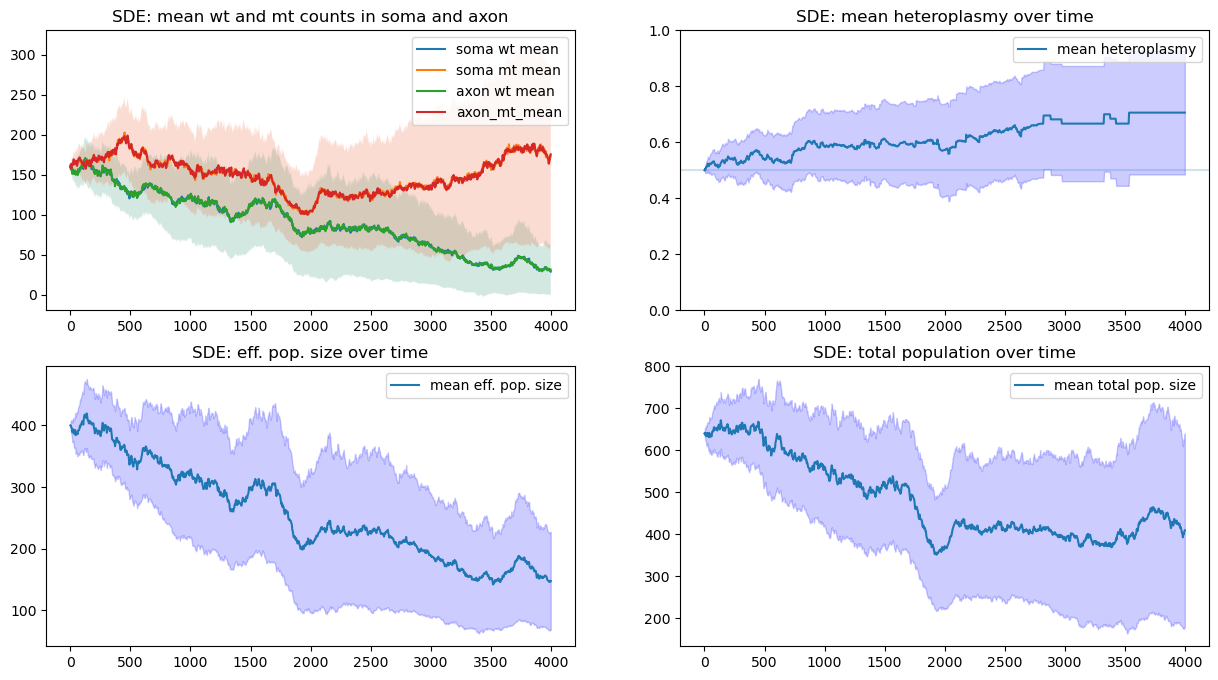


 ----- 


<<<< STARTING SIMULATION WITH C_B = 1e-07 >>>>

simulating using gillespie...


100%|██████████| 60/60 [00:13<00:00,  4.60it/s]



Copy number:
wilcox. test: less p= 0.0003
pooled t test: none p= 0.2018
mk trend: decreasing p= 0.0
kpss: non-stationary p= 0.01

Eff. pop. size:
wilcox. test: less p= 0.0
pooled t test: less p= 0.0362
mk trend: decreasing p= 0.0
kpss: non-stationary p= 0.01

Heteroplasmy:
wilcox. test: none p= 0.391
pooled t test: none p= 0.2149
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

           t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  s_wt_mean  s_wt_sem  s_mt_mean  s_mt_sem  a_wt_mean  a_wt_sem  a_mt_mean  a_mt_sem
0        0.0   640.00     0.0    400.00     0.00    0.5000   0.0000     0.00   0.0000  0.0000     160.00       0.0     160.00       0.0     160.00      0.00     160.00      0.00
1000  4000.0   492.02   180.8    234.15    81.85    0.6429   0.1281     0.15   0.0833  0.7667      73.97      36.4     171.13      85.0      74.23     36.44     172.68     85.57



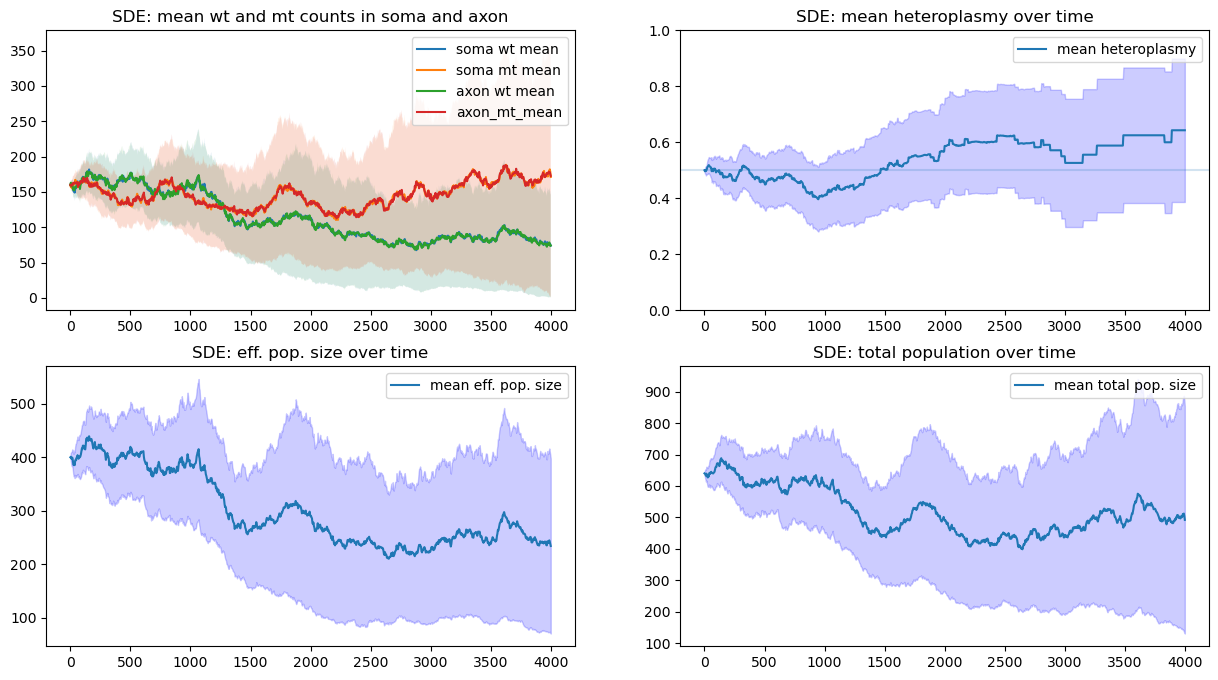

simulating using tau leaping...


100%|██████████| 60/60 [00:09<00:00,  6.56it/s]



Copy number:
wilcox. test: less p= 0.0015
pooled t test: none p= 0.5404
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.0436

Eff. pop. size:
wilcox. test: greater p= 0.0055
pooled t test: none p= 0.9546
mk trend: increasing p= 0.0
kpss: non-stationary p= 0.01

Heteroplasmy:
wilcox. test: none p= 0.1909
pooled t test: none p= 0.3791
mk trend: decreasing p= 0.0
kpss: non-stationary p= 0.01

           t  ps_mean  ps_sem  eps_mean  eps_sem  het_mean  het_sem  p_het_1  p_het_0  p_pop0  s_wt_mean  s_wt_sem  s_mt_mean  s_mt_sem  a_wt_mean  a_wt_sem  a_mt_mean  a_mt_sem
0        0.0   640.00    0.00    400.00      0.0    0.5000   0.0000     0.00   0.0000  0.0000      160.0      0.00     160.00      0.00     160.00      0.00      160.0      0.00
1000  4000.0   617.27  180.16    408.43    132.3    0.3228   0.1189     0.05   0.1333  0.7833      168.8     64.33     138.85     63.78     170.02     64.62      139.6     64.29



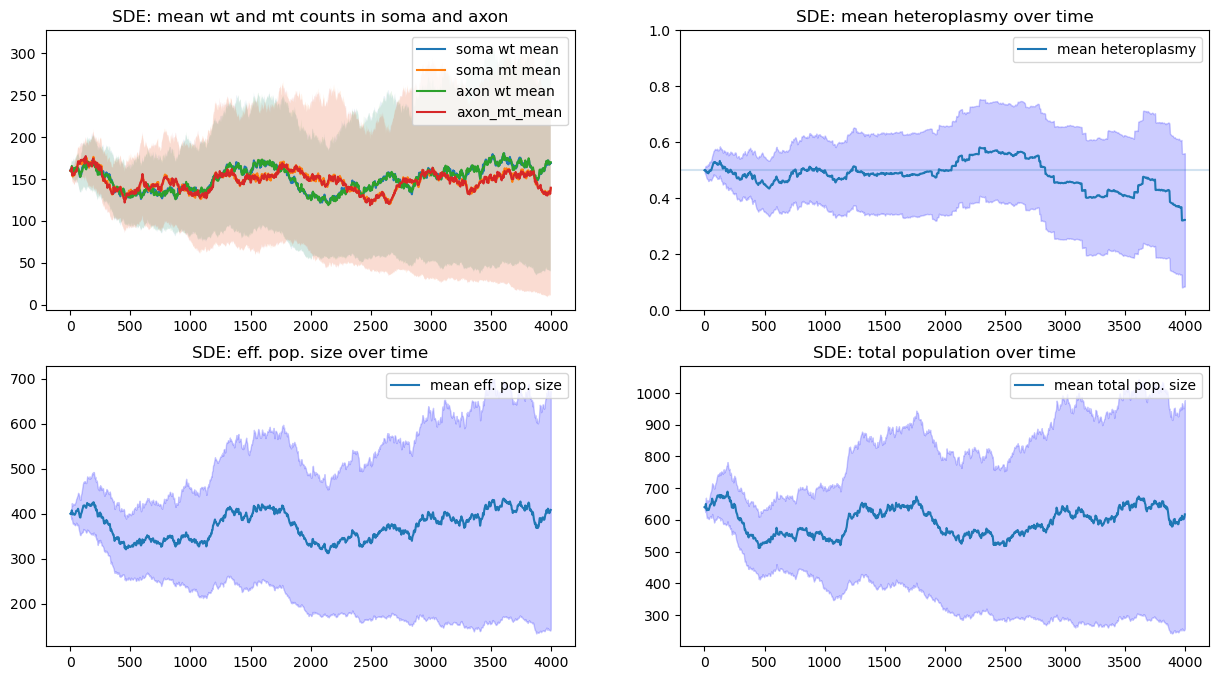


 ----- 


<<<< STARTING SIMULATION WITH C_B = 1e-08 >>>>

simulating using gillespie...


 92%|█████████▏| 55/60 [00:10<00:01,  4.68it/s]Process ForkPoolWorker-264:
Process ForkPoolWorker-255:
Process ForkPoolWorker-254:
Process ForkPoolWorker-259:
Process ForkPoolWorker-262:
Process ForkPoolWorker-256:
Process ForkPoolWorker-257:
Process ForkPoolWorker-258:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/daniel/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/daniel/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/daniel/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/daniel/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/daniel/anaconda3/l

KeyboardInterrupt: 

In [15]:
TIME_POINTS = np.linspace(0, 4000, 1001)
REP = 60


stats_df = pd.DataFrame()

for c_b in C_B_val:
    print(f"\n<<<< STARTING SIMULATION WITH C_B = {c_b} >>>>\n")
    
    for node, data in G.nodes(data = True):
        if data['nodetype'] == 1:
            data['c_b'] = c_b

#     # infer the ode model
#     ode_model = ode_from_network(G, prnt=True)

#     # run the ode model
#     ode_results = simulate_ode(ode_model, TIME_POINTS, START_STATE)
#     plot_ode_results(ode_results, TIME_POINTS, DELTA, VARS, NODES, prnt=False)

    # infer the parameterse of the sde systems
    SDE_PARAM = sde_param_from_network(G, prnt=False)

    # run the gillespie simulation
    gillespie_results = simulate_gillespie(SDE_PARAM, TIME_POINTS, START_STATE, replicates=REP)
    df_g, stats_g = two_component_statistics(gillespie_results, TIME_POINTS, DELTA)
    
    stats_g['simtype'] = 'g'
    stats_g['cb'] = c_b
    stats_df = stats_df.append(pd.Series(stats_g), ignore_index=True)
    
    print(df_g.iloc[[0, -1]]);print()
    plot_twocomponent_results(df_g)
    
    
    # run the tau leaping simulation
    tauleaping_results = simulate_tauleaping(SDE_PARAM, TIME_POINTS, START_STATE, replicates=REP, timestep=0.005)
    df_t, stats_t = two_component_statistics(tauleaping_results, TIME_POINTS, DELTA)
    
    stats_t['simtype'] = 't'
    stats_t['cb'] = c_b
    stats_df = stats_df.append(pd.Series(stats_t), ignore_index=True)
    
    print(df_t.iloc[[0, -1]]);print()
    plot_twocomponent_results(df_t)
    
    print("\n ----- \n")
    
print(stats_df)